# 1. Build an object detection model using pytorch

In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import time
import torchvision
from PIL import Image
from tqdm import tqdm
import torch
from torch.nn import Identity
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


In [2]:
traindf = pd.read_csv("/kaggle/input/cow-stall-images/Train.csv")
testdf = pd.read_csv("/kaggle/input/cow-stall-images/Test.csv")
# traindf.dropna(inplace=True)
# testdf.dropna(inplace=True)

# print(len(traindf), len(testdf))
print("Top 5 classes:", traindf.class_names.value_counts(normalize=True)[:5])
labels = traindf.class_names.unique()
print("Total classes:", len(traindf.class_names.unique()))

direc = "/kaggle/input/cow-stall-images/Stall_num_images/Stall_num_images"
# traindf.dropna(inplace=True)
train_le = LabelEncoder()
# traindf['enc_clsnms'] = train_le.fit_transform(traindf.class_names)
test_le = LabelEncoder()
# testdf['enc_clsnms'] = test_le.fit_transform(testdf.class_names)
traindf.head()

Top 5 classes: 0     0.174664
28    0.026871
14    0.021113
31    0.018234
3     0.018234
Name: class_names, dtype: float64
Total classes: 61


,imageFilename,box_position_1,box_position_2,box_position_3,box_position_4,class_names
0,GH030066_4679.png,287.0,116.0,25.0,23.0,29
1,GH020058_19383.png,275.0,58.0,23.0,24.0,44
2,GH030061_1269.png,306.0,74.0,26.0,25.0,13
3,GH020058_17235.png,NaN,NaN,NaN,NaN,0
4,GH020058_18319.png,288.0,55.0,23.0,23.0,42


In [3]:
IMG_WIDTH =  256
IMG_HEIGHT =  256
train_transforms = T.Compose(
    [
        T.Resize((IMG_WIDTH, IMG_HEIGHT)),
        T.RandomHorizontalFlip(p=0.3),
        T.RandomVerticalFlip(p=0.3),
        T.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT)),
#         T.ColorJitter(),
        T.ToTensor(),
#         T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

test_transforms = T.Compose(
    [
        T.Resize((IMG_WIDTH, IMG_HEIGHT)),
#         T.ColorJitter(),

        T.ToTensor(),
#         T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
) 
class StallDataset(Dataset):
    def __init__(self, img_dir, df, transforms):
        self.img_dir = img_dir
        self.file_name = df['imageFilename'].tolist()
        self.x = df['box_position_1'].tolist()
        self.y = df['box_position_2'].tolist()
        self.height = df['box_position_3'].tolist()
        self.width = df['box_position_4'].tolist()
        self.label = df['class_names'].tolist()
        self.transforms = transforms
#     def transform(self, image, mask):
#         pass
 
    
    def mask_to_box(self,mask):
        if len(np.where(mask==255)[0]) > 0:
            x_scale, y_scale = np.where(mask==255)[1:]

            bbox = torch.tensor([x_scale.min(), y_scale.min(),x_scale.max()-x_scale.min(),y_scale.max()-y_scale.min()])
        else:
            bbox = torch.tensor([0,0,0,0])
        return bbox


        
    def __len__(self):
        return len(self.file_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_name[idx])
        img = Image.open(img_path) 
        label = torch.tensor(self.label[idx], dtype = torch.long)
        mask = np.zeros((img.size[1], img.size[0]))
        bbox = [self.x[idx],self.y[idx],self.height[idx],self.width[idx]]
        bbox = np.array(bbox)
        if bbox.any():
            bbox = np.array(bbox, dtype = 'int')
        else:
            bbox = np.array([0, 0, 0, 0], dtype='int')
        mask[bbox[1]:bbox[1]+bbox[3]+1,bbox[0]:bbox[0]+bbox[2]+1]=255
        mask = Image.fromarray(mask)
       
       
        img, mask = self.transforms(img), self.transforms(mask)

            
        bbox = self.mask_to_box(mask)

        return img, label, bbox
    

In [4]:
batch_size = 64
train_dataset = StallDataset(direc,traindf, transforms=train_transforms)
test_dataset = StallDataset(direc,testdf,  transforms = test_transforms)

train_dl = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
for img,box, _ in train_dl:
    print(box)
    break

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in long_scalars


tensor([29, 33, 50, 58, 55, 44, 26, 54, 15, 46, 42, 27, 58, 35, 58, 37, 42,  0,
         2, 31,  2, 55, 29, 39, 29, 22,  7, 12, 20, 35,  0, 54, 58, 57, 20, 55,
         0, 46, 32, 27, 57, 28, 28, 18,  0, 25, 57,  0, 26, 57, 17, 43, 26, 13,
         0,  0, 13,  1, 53, 19, 31,  0, 48,  4])


In [6]:
def get_inverse_dist(ds):
    lbls = []
    for img, lbl, bx in ds:
        lbls.extend(lbl.flatten().tolist())
    return lbls

lbls = get_inverse_dist(train_dataset)
lbls.extend(get_inverse_dist(test_dataset))
from collections import Counter

counts = dict(Counter(lbls))
classes, cts = np.array(list(counts.keys())), np.array(list(counts.values()))

invs_weights = 1 - np.array(cts)/len(train_dataset)
print(classes)
print(cts)
print(invs_weights)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in long_scalars


In [8]:
# class InceptionBlock(nn.Module):
#     def __init__(self, in_channels, filters):
#         super().__init__()
#         self.branch1x1 = nn.Conv2d(in_channels, filters[0], kernel_size=1)
#         self.branch3x3_1 = nn.Conv2d(in_channels, filters[1], kernel_size=1)
#         self.branch3x3_2 = nn.Conv2d(filters[1], filters[1], kernel_size=3, padding=1)
#         self.branch5x5_1 = nn.Conv2d(in_channels, filters[2], kernel_size=1)
#         self.branch5x5_2 = nn.Conv2d(filters[2], filters[2], kernel_size=5, padding=2)
#         self.branch_pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
#         self.branch_pool_conv = nn.Conv2d(in_channels, filters[3], kernel_size=1)
#         self.relu = nn.ReLU(inplace=True)
#         self.classifier = nn.Sequential(
#             nn.Conv2d(59, 59, 3),
#             nn.MaxPool2d(3),
#             nn.Conv2d(59, 59, 3),
#             nn.MaxPool2d(3),
#             nn.Conv2d(59, 59, 3),
#             nn.MaxPool2d(3),
#             nn.Conv2d(59, 59, 3),
#             nn.MaxPool2d(3),
#             nn.Flatten(),
#             nn.Linear(59*4*2, 2000)
#         )

#     def forward(self, x):
#         branch1x1 = self.relu(self.branch1x1(x))
#         branch3x3 = self.relu(self.branch3x3_2(self.branch3x3_1(x)))
#         branch5x5 = self.relu(self.branch5x5_2(self.branch5x5_1(x)))
#         branch_pool = self.relu(self.branch_pool_conv(self.branch_pool(x)))
#         out = torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1)
#         out = self.classifier(out)
#         return out

# incept = InceptionBlock(3, [3, 8, 16, 32])
# incept(img).shape

In [9]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, 1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(3),
            nn.Conv2d(8, 16, 1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(3),
            nn.Conv2d(16, 32, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*12*12, 61),
            nn.Sigmoid())
    def forward(self, img):
        return self.classifier(img)
cusmodel = CustomModel()
cusmodel(img).shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (49152x256 and 4608x61)

In [10]:
class StallDetector(nn.Module):
    def __init__(self, baseModel, numClasses):
        super(StallDetector, self).__init__()
        # initialize the base model and the number of classes
        self.baseModel = baseModel
        self.numClasses = numClasses
        # build the regressor head for outputting the bounding box
        # coordinates
        self.regressor = nn.Sequential(
            nn.Linear(baseModel.fc.in_features, 128),
#             nn.Linear(baseModel.classifier[-1].out_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4),
#             nn.Sigmoid()
        )
        # build the classifier head to predict the class labels
        self.classifier = nn.Sequential(
            nn.Linear(baseModel.fc.in_features, 512),
#             nn.Linear(baseModel.classifier[-1].out_features, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, self.numClasses),
            nn.Sigmoid()
        )
        # set the classifier of our base model to produce outputs
        # from the last convolution block
        self.baseModel.fc = Identity()
    def forward(self, x):
        # pass the inputs through the base model and then obtain
        # predictions from two different branches of the network
        features = self.baseModel(x)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)
        # return the outputs as a tuple
        return (bboxes, classLogits)
    

In [11]:
from torchvision.models import resnet34, ResNet34_Weights
def IOU_score(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    
    # Calculate the area of the intersection rectangle
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    # Calculate the area of the union rectangle
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate the IOU score
    iou_score = intersection_area / union_area
    
    return iou_score

class DetectStallResnet(nn.Module):
    def __init__(self, num_classes=61, num_coordinates=4):
        super(DetectStallResnet, self).__init__()
        self.resnet = torchvision.models.resnet34(pretrained=True)

        #delete the last layer - to use ResNet50 as a feature extractor
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.classes= nn.Sequential(
            nn.Linear(512, num_classes),
       
        )
        self.coordinates = nn.Sequential(
            nn.Linear(512, num_coordinates)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        coordinates = self.coordinates(x)
        labels=self.classes(x)
        return labels, coordinates

In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        '''
        :param inputs: batch_size * dim
        :param targets: (batch,)
        :return:
        '''
        bce_loss = F.cross_entropy(inputs, targets)
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [13]:
def loss_function(box_target, box_pred, class_target, class_pred):
    _, pred_classes = torch.max(class_pred, dim=1)
    count = (pred_classes == class_target).sum().item()
    
    iou_losses = []
    box_losses = []
    class_loss = nn.CrossEntropyLoss(weight=torch.tensor(invs_weights).type(torch.float).to(device))(class_pred, class_target)
    
    for i in range(len(box_pred)):
        iou_loss = 1 - IOU_score(box_pred[i], box_target[i])
        iou_losses.append(iou_loss)
        
        box_loss = F.smooth_l1_loss(box_pred[i], box_target[i], reduction='mean')
        box_losses.append(box_loss)
    
    iou_losses = torch.tensor(iou_losses).to(device)
    iou_loss = iou_losses.mean()
    
    box_losses = torch.tensor(box_losses).to(device)
    box_loss = box_losses.mean()

    loss = 1.0 * class_loss + 0.1 * box_loss + 5.0 * iou_loss
    return loss, count, iou_loss.item()

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# classLossFunc = nn.CrossEntropyLoss(weight=torch.tensor(invs_weights).type(torch.float).to(device))
# classLossFunc = nn.SmoothL1Loss(reduction='mean')
classLossFunc = loss_function
# base = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1 )
# for param in base.parameters():
#     param.requires_grad = True
# model = StallDetector(base, 61)
# model = model.to(device)
model = DetectStallResnet().to(device)
# model = CustomModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1/1000)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
total = len(list(model.resnet.children()))
for i, layer in enumerate(model.resnet.children()):
    if i >= total - 3: 
        for param in layer.parameters():
            param.requires_grad = True



for param in model.classes.parameters():
    param.requires_grad = True


for param in model.coordinates.parameters():
    param.requires_grad = True

# 2. Train your model using [cow stall number datasets](https://github.com/YoushanZhang/Cow_stall_number)

In [17]:
import torch.nn.functional as F
print("[INFO] training the network...")
num_epochs = 300
max_val = 75
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for e in range(num_epochs):
    print("Epoch:", e)
    startTime = time.time()
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (images, labels, bboxes) in tqdm(train_dl):
        (images, labels, bboxes) = (images.to(device),
            labels.to(device), bboxes.to(device))
        class_pred, box_pred = model(images)
        classLoss, count, iou = loss_function(bboxes, box_pred, labels, class_pred)

        l2_regularization = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
        classLoss += 0.01 * l2_regularization
        opt.zero_grad()
        classLoss.backward()
        opt.step()
        totalTrainLoss += classLoss
        trainCorrect += count
    avg_acc = (trainCorrect/len(train_dataset))*100
    train_accs.append(avg_acc)
    train_losses.append((totalTrainLoss/len(train_dl)).item()*100)
        
    print("Train acc:", avg_acc)   
    with torch.no_grad():
        model.eval()
        for (images, labels, bboxes) in tqdm(test_dl):
            (images, labels, bboxes) = (images.to(device),
                labels.to(device), bboxes.to(device))
            class_pred, box_pred = model(images)

            classLoss, count, iou = loss_function(bboxes, box_pred, labels, class_pred)
        # calculate the number of correct predictions
            valCorrect += count
            totalValLoss += classLoss
            
        avg_acc = (valCorrect/len(test_dataset))*100
        val_accs.append(avg_acc)
        val_losses.append((totalValLoss/len(test_dataset)).item()*100)
    
    print("Val Acc:", avg_acc)
    if avg_acc > max_val:
        name = f'stall_number_detector{avg_acc}.pth'
        torch.save(model.state_dict(), name)  
        max_val=avg_acc

[INFO] training the network...
Epoch: 0


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 20.34548944337812


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 15.32567049808429
Epoch: 1


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 20.34548944337812


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 22.60536398467433
Epoch: 2


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 21.401151631477926


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 13.026819923371647
Epoch: 3


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 24.280230326295584


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 16.85823754789272
Epoch: 4


100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Train acc: 25.143953934740882


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 19.54022988505747
Epoch: 5


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 26.67946257197697


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Val Acc: 22.22222222222222
Epoch: 6


100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Train acc: 27.927063339731284


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Acc: 21.455938697318008
Epoch: 7


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 28.310940499040306


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val Acc: 21.0727969348659
Epoch: 8


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 29.750479846449135


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 21.0727969348659
Epoch: 9


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Train acc: 28.406909788867562


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 23.754789272030653
Epoch: 10


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 29.270633397312864


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 28.735632183908045
Epoch: 11


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 34.357005758157385


100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Val Acc: 26.053639846743295
Epoch: 12


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 33.10940499040307


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 25.67049808429119
Epoch: 13


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 35.50863723608445


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 29.88505747126437
Epoch: 14


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 35.12476007677543


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 16.85823754789272
Epoch: 15


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 37.42802303262956


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Val Acc: 29.118773946360154
Epoch: 16


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 39.34740882917466


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 24.521072796934863
Epoch: 17


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 40.49904030710173


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 28.35249042145594
Epoch: 18


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 40.978886756238005


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Val Acc: 22.60536398467433
Epoch: 19


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 39.731285988483684


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 30.65134099616858
Epoch: 20


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 40.30710172744721


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Acc: 27.586206896551722
Epoch: 21


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 40.11516314779271


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 35.24904214559387
Epoch: 22


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 41.938579654510555


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 31.03448275862069
Epoch: 23


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 45.105566218809976


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Val Acc: 16.85823754789272
Epoch: 24


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 47.69673704414588


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 24.521072796934863
Epoch: 25


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 43.282149712092135


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 33.71647509578544
Epoch: 26


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 43.47408829174665


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 32.95019157088122
Epoch: 27


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 44.4337811900192


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 36.015325670498086
Epoch: 28


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 48.464491362763916


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 41.7624521072797
Epoch: 29


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Train acc: 44.241842610364685


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 29.88505747126437
Epoch: 30


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 47.408829174664106


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 18.007662835249043
Epoch: 31


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 47.88867562380039


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 31.03448275862069
Epoch: 32


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 47.79270633397313


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val Acc: 41.7624521072797
Epoch: 33


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 48.94433781190019


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 19.157088122605366
Epoch: 34


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 46.64107485604607


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Val Acc: 31.417624521072796
Epoch: 35


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 49.90403071017274


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 40.61302681992337
Epoch: 36


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 50.19193857965452


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 24.137931034482758
Epoch: 37


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 52.11132437619962


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 33.71647509578544
Epoch: 38


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 51.24760076775432


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 25.67049808429119
Epoch: 39


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 55.3742802303263


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 37.547892720306514
Epoch: 40


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 54.606525911708246


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Val Acc: 41.37931034482759
Epoch: 41


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 52.783109404990405


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 36.39846743295019
Epoch: 42


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 53.35892514395394


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 37.93103448275862
Epoch: 43


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 56.4299424184261


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 24.521072796934863
Epoch: 44


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 51.631477927063344


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 41.37931034482759
Epoch: 45


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 53.454894433781185


100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Val Acc: 41.7624521072797
Epoch: 46


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 54.702495201535505


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Val Acc: 47.509578544061306
Epoch: 47


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 56.90978886756238


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 32.95019157088122
Epoch: 48


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 58.25335892514395


100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Val Acc: 43.67816091954023
Epoch: 49


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 57.48560460652591


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 35.63218390804598
Epoch: 50


100%|██████████| 17/17 [00:17<00:00,  1.06s/it]


Train acc: 58.25335892514395


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 46.74329501915709
Epoch: 51


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 60.55662188099809


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 42.911877394636015
Epoch: 52


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 59.02111324376199


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 37.93103448275862
Epoch: 53


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 58.73320537428023


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 31.417624521072796
Epoch: 54


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 59.88483685220729


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 51.34099616858238
Epoch: 55


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 59.11708253358925


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 52.10727969348659
Epoch: 56


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 56.52591170825336


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 60.91954022988506
Epoch: 57


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 57.00575815738963


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 47.89272030651341
Epoch: 58


100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


Train acc: 58.829174664107484


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 29.88505747126437
Epoch: 59


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 60.65259117082533


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val Acc: 27.203065134099617
Epoch: 60


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 59.40499040307101


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 38.69731800766284
Epoch: 61


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 57.00575815738963


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 49.808429118773944
Epoch: 62


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 62.95585412667947


100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Val Acc: 25.287356321839084
Epoch: 63


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 60.74856046065259


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 45.593869731800766
Epoch: 64


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 62.47600767754319


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Val Acc: 50.191570881226056
Epoch: 65


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 60.46065259117083


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val Acc: 54.406130268199234
Epoch: 66


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 57.86948176583493


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 36.015325670498086
Epoch: 67


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 61.99616122840691


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 40.99616858237548
Epoch: 68


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 62.09213051823417


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val Acc: 47.509578544061306
Epoch: 69


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 64.77927063339732


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val Acc: 36.015325670498086
Epoch: 70


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 64.58733205374281


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val Acc: 57.08812260536399
Epoch: 71


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 67.08253358925144


100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Val Acc: 37.16475095785441
Epoch: 72


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 65.54702495201535


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 55.55555555555556
Epoch: 73


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 64.01151631477927


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Val Acc: 53.25670498084292
Epoch: 74


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 63.339731285988485


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 41.37931034482759
Epoch: 75


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 65.83493282149712


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 48.275862068965516
Epoch: 76


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 65.4510556621881


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Val Acc: 45.21072796934866
Epoch: 77


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 60.172744721689064


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 42.5287356321839
Epoch: 78


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 63.62763915547025


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 39.84674329501915
Epoch: 79


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 64.10748560460652


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 54.406130268199234
Epoch: 80


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 65.83493282149712


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 50.57471264367817
Epoch: 81


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 65.93090211132437


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 50.191570881226056
Epoch: 82


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 65.54702495201535


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 28.35249042145594
Epoch: 83


100%|██████████| 17/17 [00:18<00:00,  1.08s/it]


Train acc: 66.60268714011515


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 57.47126436781609
Epoch: 84


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 67.94625719769674


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 39.84674329501915
Epoch: 85


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 63.81957773512475


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 58.23754789272031
Epoch: 86


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 64.68330134357005


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 45.593869731800766
Epoch: 87


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 67.46641074856046


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 49.042145593869726
Epoch: 88


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 64.68330134357005


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 48.65900383141762
Epoch: 89


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 66.3147792706334


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 49.808429118773944
Epoch: 90


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 64.58733205374281


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Val Acc: 43.29501915708812
Epoch: 91


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 67.94625719769674


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 62.45210727969349
Epoch: 92


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 69.00191938579654


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val Acc: 34.86590038314176
Epoch: 93


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Train acc: 68.33013435700576


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 44.06130268199234
Epoch: 94


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 68.13819577735126


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 69.34865900383141
Epoch: 95


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 66.98656429942419


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 37.547892720306514
Epoch: 96


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 65.54702495201535


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 54.02298850574713
Epoch: 97


100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


Train acc: 65.06717850287907


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val Acc: 68.5823754789272
Epoch: 98


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 69.57773512476008


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 67.43295019157088
Epoch: 99


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 72.36084452975048


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val Acc: 71.26436781609196
Epoch: 100


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 71.20921305182341


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 53.63984674329502
Epoch: 101


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 69.48176583493282


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 44.44444444444444
Epoch: 102


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Train acc: 70.34548944337811


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 60.53639846743295
Epoch: 103


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 68.04222648752399


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 43.67816091954023
Epoch: 104


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 69.28982725527831


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Acc: 52.490421455938694
Epoch: 105


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 67.56238003838772


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 46.74329501915709
Epoch: 106


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 67.17850287907869


100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Val Acc: 66.66666666666666
Epoch: 107


100%|██████████| 17/17 [00:16<00:00,  1.02it/s]


Train acc: 67.94625719769674


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 57.8544061302682
Epoch: 108


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 65.16314779270633


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 70.49808429118774
Epoch: 109


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 70.15355086372361


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 59.00383141762452
Epoch: 110


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 70.63339731285988


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 62.45210727969349
Epoch: 111


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 67.17850287907869


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 67.04980842911877
Epoch: 112


100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


Train acc: 67.65834932821497


100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Val Acc: 36.7816091954023
Epoch: 113


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 69.09788867562379


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Val Acc: 68.5823754789272
Epoch: 114


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 67.27447216890596


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val Acc: 57.47126436781609
Epoch: 115


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 69.00191938579654


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 58.23754789272031
Epoch: 116


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 70.92130518234165


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 63.601532567049816
Epoch: 117


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 71.11324376199616


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 59.00383141762452
Epoch: 118


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Train acc: 71.59309021113243


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Val Acc: 65.90038314176245
Epoch: 119


100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Train acc: 67.94625719769674


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val Acc: 67.43295019157088
Epoch: 120


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 71.78502879078695


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 72.03065134099617
Epoch: 121


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 71.11324376199616


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 54.78927203065134
Epoch: 122


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 71.49712092130518


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 50.95785440613027
Epoch: 123


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 70.72936660268714


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 39.46360153256705
Epoch: 124


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 67.94625719769674


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 53.25670498084292
Epoch: 125


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 69.86564299424184


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 65.13409961685824
Epoch: 126


100%|██████████| 17/17 [00:18<00:00,  1.09s/it]


Train acc: 69.19385796545106


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 62.06896551724138
Epoch: 127


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 69.19385796545106


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 29.88505747126437
Epoch: 128


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 69.28982725527831


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 56.32183908045977
Epoch: 129


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 67.75431861804223


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 33.71647509578544
Epoch: 130


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 68.33013435700576


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 24.137931034482758
Epoch: 131


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 69.67370441458733


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 57.47126436781609
Epoch: 132


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 67.17850287907869


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Val Acc: 64.75095785440614
Epoch: 133


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 71.49712092130518


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 75.47892720306514


NameError: name 'val_acc' is not defined

In [18]:
for e in range(num_epochs):
    print("Epoch:", e)
    startTime = time.time()
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for (images, labels, bboxes) in tqdm(train_dl):
        (images, labels, bboxes) = (images.to(device),
            labels.to(device), bboxes.to(device))
        class_pred, box_pred = model(images)
        classLoss, count, iou = loss_function(bboxes, box_pred, labels, class_pred)

        l2_regularization = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
        classLoss += 0.01 * l2_regularization
        opt.zero_grad()
        classLoss.backward()
        opt.step()
        totalTrainLoss += classLoss
        trainCorrect += count
    avg_acc = (trainCorrect/len(train_dataset))*100
    train_accs.append(avg_acc)
    train_losses.append((totalTrainLoss/len(train_dl)).item()*100)
        
    print("Train acc:", avg_acc)   
    with torch.no_grad():
        model.eval()
        for (images, labels, bboxes) in tqdm(test_dl):
            (images, labels, bboxes) = (images.to(device),
                labels.to(device), bboxes.to(device))
            class_pred, box_pred = model(images)

            classLoss, count, iou = loss_function(bboxes, box_pred, labels, class_pred)
        # calculate the number of correct predictions
            valCorrect += count
            totalValLoss += classLoss
            
        avg_acc = (valCorrect/len(test_dataset))*100
        val_accs.append(avg_acc)
        val_losses.append((totalValLoss/len(test_dataset)).item()*100)
    
    print("Val Acc:", avg_acc)
    if avg_acc > max_val:
        name = f'stall_number_detector{avg_acc}.pth'
        torch.save(model.state_dict(), name)  
        max_val=avg_acc

Epoch: 0


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 71.6890595009597


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 68.96551724137932
Epoch: 1


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 72.16890595009598


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 68.19923371647509
Epoch: 2


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 71.49712092130518


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 63.984674329501914
Epoch: 3


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 69.96161228406909


100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Val Acc: 55.938697318007655
Epoch: 4


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 71.59309021113243


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 59.00383141762452
Epoch: 5


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 71.40115163147792


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 61.30268199233716
Epoch: 6


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


Train acc: 71.6890595009597


100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Val Acc: 63.601532567049816
Epoch: 7


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 70.92130518234165


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 52.87356321839081
Epoch: 8


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 71.6890595009597


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 66.28352490421456
Epoch: 9


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 72.45681381957773


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 70.88122605363985
Epoch: 10


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 72.26487523992321


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 72.79693486590038
Epoch: 11


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 72.26487523992321


100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Val Acc: 59.77011494252874
Epoch: 12


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 69.00191938579654


100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Val Acc: 62.45210727969349
Epoch: 13


100%|██████████| 17/17 [00:17<00:00,  1.00s/it]


Train acc: 71.0172744721689


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 58.23754789272031
Epoch: 14


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 69.19385796545106


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 63.601532567049816
Epoch: 15


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Train acc: 69.76967370441459


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 64.36781609195403
Epoch: 16


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 71.6890595009597


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 72.41379310344827
Epoch: 17


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 73.51247600767753


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 62.83524904214559
Epoch: 18


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 74.76007677543186


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 53.25670498084292
Epoch: 19


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 73.89635316698656


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 67.43295019157088
Epoch: 20


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 72.45681381957773


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 62.45210727969349
Epoch: 21


100%|██████████| 17/17 [00:16<00:00,  1.01it/s]


Train acc: 71.30518234165068


100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Val Acc: 61.68582375478927
Epoch: 22


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 75.23992322456814


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 64.75095785440614
Epoch: 23


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 70.72936660268714


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Val Acc: 63.2183908045977
Epoch: 24


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 71.59309021113243


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 37.547892720306514
Epoch: 25


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 71.30518234165068


100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Val Acc: 56.70498084291188
Epoch: 26


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 70.44145873320538


100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Val Acc: 45.593869731800766
Epoch: 27


100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


Train acc: 72.07293666026871


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val Acc: 57.08812260536399
Epoch: 28


100%|██████████| 17/17 [00:18<00:00,  1.09s/it]


Train acc: 74.18426103646834


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 77.01149425287356
Epoch: 29


100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Train acc: 71.8809980806142


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 43.67816091954023
Epoch: 30


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 72.84069097888676


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 43.29501915708812
Epoch: 31


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 73.70441458733205


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val Acc: 55.55555555555556
Epoch: 32


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 70.24952015355086


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 57.8544061302682
Epoch: 33


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 71.40115163147792


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 56.70498084291188
Epoch: 34


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 71.11324376199616


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 52.490421455938694
Epoch: 35


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 71.78502879078695


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 57.08812260536399
Epoch: 36


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 72.93666026871402


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 69.34865900383141
Epoch: 37


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 71.78502879078695


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val Acc: 59.77011494252874
Epoch: 38


100%|██████████| 17/17 [00:17<00:00,  1.01s/it]


Train acc: 72.36084452975048


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 62.83524904214559
Epoch: 39


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 74.85604606525912


100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Val Acc: 65.51724137931035
Epoch: 40


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 73.89635316698656


100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Val Acc: 41.7624521072797
Epoch: 41


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 73.12859884836853


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 77.01149425287356
Epoch: 42


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 74.28023032629558


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 68.19923371647509
Epoch: 43


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 72.552783109405


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 49.808429118773944
Epoch: 44


100%|██████████| 17/17 [00:18<00:00,  1.06s/it]


Train acc: 72.93666026871402


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 62.45210727969349
Epoch: 45


100%|██████████| 17/17 [00:17<00:00,  1.06s/it]


Train acc: 74.76007677543186


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 70.11494252873564
Epoch: 46


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 75.04798464491363


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Val Acc: 68.5823754789272
Epoch: 47


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 73.41650671785028


100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Val Acc: 59.38697318007663
Epoch: 48


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 74.4721689059501


100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Val Acc: 69.34865900383141
Epoch: 49


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 73.89635316698656


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 64.36781609195403
Epoch: 50


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 73.41650671785028


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 53.25670498084292
Epoch: 51


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 72.26487523992321


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Val Acc: 49.42528735632184
Epoch: 52


100%|██████████| 17/17 [00:16<00:00,  1.00it/s]


Train acc: 70.15355086372361


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 66.28352490421456
Epoch: 53


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 71.49712092130518


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 60.53639846743295
Epoch: 54


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 73.22456813819578


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Val Acc: 64.36781609195403
Epoch: 55


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 71.78502879078695


100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Val Acc: 44.44444444444444
Epoch: 56


100%|██████████| 17/17 [00:17<00:00,  1.05s/it]


Train acc: 72.16890595009598


100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Val Acc: 58.620689655172406
Epoch: 57


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 72.84069097888676


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 50.95785440613027
Epoch: 58


100%|██████████| 17/17 [00:17<00:00,  1.03s/it]


Train acc: 73.70441458733205


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 56.70498084291188
Epoch: 59


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]


Train acc: 72.45681381957773


100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Val Acc: 29.118773946360154
Epoch: 60


100%|██████████| 17/17 [00:17<00:00,  1.02s/it]


Train acc: 74.76007677543186


100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Val Acc: 77.77777777777779
Epoch: 61


  0%|          | 0/17 [00:00<?, ?it/s]


KeyboardInterrupt: 

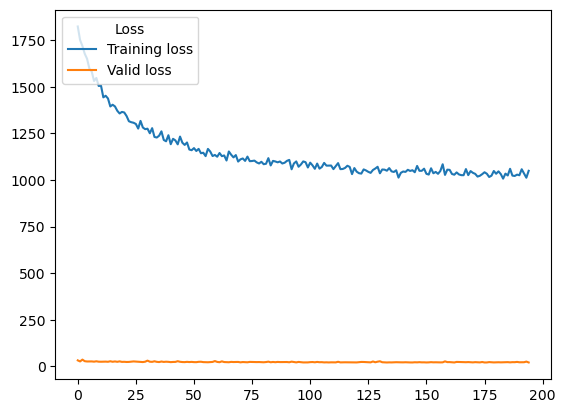

In [32]:
plt.plot(train_losses,label='Training loss')
plt.plot(val_losses, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

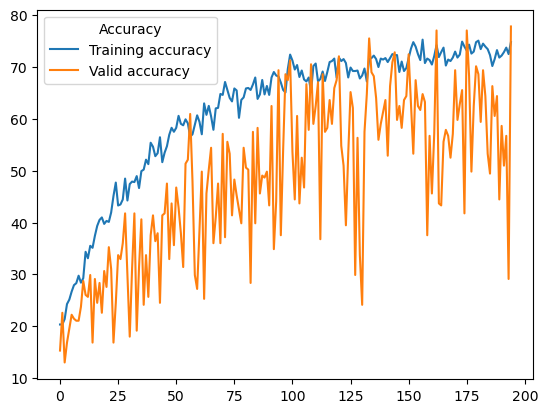

In [21]:
plt.plot(train_accs,label='Training accuracy')
plt.plot(val_accs, label='Valid accuracy')
plt.legend(loc='upper left', title='Accuracy');

# 3.Evaluate your model using the test images

In [33]:
model1 = DetectStallResnet().to(device)
model1.load_state_dict(torch.load("stall_number_detector.pth"))

valCorrect = 0
totalValLoss = 0
model1.eval()
for img, lbl, box in test_dl:
    img, lbl, box = img.to(device), lbl.to(device), box.to(device)
    pre_lbl, pred_box = model1(img)
    classLoss, count, iou = loss_function(box, pred_box, lbl, pre_lbl)    
    valCorrect += count
    totalValLoss += classLoss
            
avg_acc = (valCorrect/len(test_dataset))*100
print("Test Acc:", avg_acc)
# print(totalValLoss/len(test_dataset)*100)


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in long_scalars


Test Acc: 80.07662835249042


# 5. Write a four-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://www.researchgate.net/publication/370180111_Cow_stall_number_identification_and_localization_using_Object_detection_models
